In [1]:
PATH = 'assets/twitter1.6m.csv'

In [5]:
import tensorflow as tf
tf.test.is_gpu_available()

AttributeError: module 'tensorflow' has no attribute 'test'

In [39]:
# !pip install -r requirements.txt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter

In [4]:
import re
import os
import pandas as pd
import numpy as np

In [5]:
# visualization
import warnings
warnings.filterwarnings('ignore')
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [6]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

## **2. Data exploratory analysis**


### **2.1 Data overview**



**Dataset**
The dataset being used is the given competition twitter  dataset. It contains over 1M tweets. The tweets have been annotated (0 = Negative, 4 = Positive) and they can be used to detect sentiment.
We will use 100K tweets: 50K tweets with negative sentiment  (annotated as “negative”) and 50K tweets with positive sentiment (annotated as “positive”).
The dataset contains 6 different fields, we will focus the following:
    Target (Sentiment): the emotion of the tweet (0 = negative, 4 = positive)
    Text: the text of the tweet

In [8]:
DATASET_ENCODING = "ISO-8859-1"
raw_df = pd.read_csv(PATH,encoding=DATASET_ENCODING)
raw_df.columns = ['Sentiment', 'id', 'date', 'q','username' ,'SentimentText']
raw_df.head()

,Sentiment,id,date,q,username,SentimentText
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


### **2.2 Data Exploration**

The first step is to load the data to global environment.

In [9]:
pos_df = raw_df.loc[raw_df.Sentiment == 4].sample(n=int(5e4))
neg_df = raw_df.loc[raw_df.Sentiment == 0].sample(n=int(5e4))

df = pd.concat([pos_df, neg_df], axis=0)[['Sentiment','SentimentText']]
df.head()

,Sentiment,SentimentText
1319382,4,I finally got sometime for myself today.
1100923,4,"@Nicxo yeaaah, well hopefully they will phone ..."
1226390,4,@punkofevil ooh maybe you'll have fun with gli...
1454628,4,"@wyndwitch don't believe you, not if you are t..."
1016644,4,@Tink10270 but u wouldn't trade me for nuthin.


We could see some abnormal words such as <br /><br />, then we should replace them by a null or space value.

### **2.3 Data pre-processing**

**Text Cleaning**

0.Label Encoder

1.Remove html tags

2.Remove special characters

3.Converting every thing to lower case

4.Removing Stop words

5.Stemming

6.Remove extra spaces

7.Lemmatization

In [10]:
label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])
df.head()

,Sentiment,SentimentText
1319382,1,I finally got sometime for myself today.
1100923,1,"@Nicxo yeaaah, well hopefully they will phone ..."
1226390,1,@punkofevil ooh maybe you'll have fun with gli...
1454628,1,"@wyndwitch don't believe you, not if you are t..."
1016644,1,@Tink10270 but u wouldn't trade me for nuthin.


In [11]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/serfata/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Reading contractions.csv and storing it as a dict.
con_path = 'assets/contractions.csv'
contractions = pd.read_csv(con_path,index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):
    tweet = tweet.lower()
    
    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
    
    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)
    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)
    
    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)
    
    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

df['SentimentText'] = df.SentimentText.apply(preprocess_apply)

**Stop Words Removal**

We'll remove the stop words for better prediction.

In [13]:
from tqdm import tqdm
nltk.download('punkt')
pbar = tqdm(total=df.shape[0], leave=True, position=0)

def remove_sw(SentimentText):
    tokens = word_tokenize(SentimentText)
    tokens = [w for w in tokens if not w in stop_words]
    pbar.update(1)
    return " ".join(tokens)

df["SentimentText"] = df["SentimentText"].apply(remove_sw)
pbar.close()

[nltk_data] Downloading package punkt to /home/serfata/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 100000/100000 [00:10<00:00, 9341.04it/s]


**Porter Stemmer**

For this particular dataset the PorterStemmer does not bring better performance, so it is better to skip this step.

In [14]:
pbar = tqdm(total=df.shape[0], leave=True, position=0)
ps = PorterStemmer()

def stem(text):
    pbar.update(1)
    return ' '.join([ps.stem(word) for word in text.split()])

df["SentimentText"] = df["SentimentText"].apply(stem)
pbar.close()

100%|██████████| 100000/100000 [00:12<00:00, 8267.86it/s]


In [15]:
nltk.download('punkt')
#Creating a Lemmatizer for preprocessing
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

[nltk_data] Downloading package punkt to /home/serfata/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
df["SentimentText"] = df["SentimentText"].apply(lambda x: re.sub(" +"," ", x))

Text(0.5, 1.0, 'Reviews polarity')

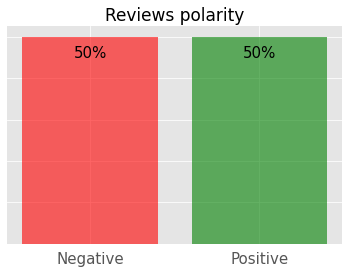

In [17]:
# Sentiment reviews distribution
s = df['Sentiment'].value_counts()
s = (s/s.sum())*100

plt.figure()
bars = plt.bar(s.index, s.values, color = ['green', 'red'], alpha = .6)
plt.xticks(s.index, ['Positive', 'Negative'], fontsize = 15)
plt.tick_params(bottom = False, top = False, left = False, right = False, labelleft = False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 5, s = str(bar.get_height())[:2] + '%', ha = 'center', fontsize = 15)
plt.title('Reviews polarity', fontsize = 17)

In [18]:
X = df['SentimentText']
y = df['Sentiment']

Split data to train and test for modeling and performance evaluation.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

print('Training dataset : {} SentimentTexts'.format(X_train.shape[0]))
print('Testing dataset : {} SentimentTexts'.format(X_test.shape[0]))

Training dataset : 90000 SentimentTexts
Testing dataset : 10000 SentimentTexts


In [20]:
y_test.value_counts()

1    5061
0    4939
Name: Sentiment, dtype: int64

## **3. Modeling**

### 3.1 Feature Extraction using TF-IDF algorithm

![TFIDF](https://miro.medium.com/max/532/0*bHkPdhgfnyTs4un_)

In scikit-learn, the TF-IDF algorithm is implemented using **TfidfTransformer**. This transformer needs the count matrix which it will transform later. Hence, we use **CountVectorizer** first.
Alternatively, one can use **TfidfVectorizer**, which is the equivalent of CountVectorizer followed by TfidfTransformer

In [21]:
nltk.download('wordnet')
tfidfVect =    TfidfVectorizer( max_df = 0.5,
                                sublinear_tf=True,
                                lowercase = True, 
                                ngram_range = (1,2), 
                                tokenizer = LemmaTokenizer(),
                                stop_words = 'english',
                                min_df = 1,
                                use_idf = True,
                                # max_features = 1000,
                                strip_accents = 'ascii'
                                )

[nltk_data] Downloading package wordnet to /home/serfata/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
%time features = tfidfVect.fit_transform(X_train)
features.shape

/home/serfata/.conda/envs/tweet/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 14.3 s, sys: 177 ms, total: 14.4 s
Wall time: 14.4 s


(90000, 376440)

In [23]:
features_test = tfidfVect.transform(X_test)

## Prediction Models: Logistic Regression and DNN

## TfIdfVectorizer Feature Extraction

**Logistic Regression**

In [24]:
from sklearn.linear_model import LogisticRegression
#instantiate the model (with the default parameters)
lr = LogisticRegression()

#fit the model with data (occurs in-place)
lr.fit(features, y_train)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#tune parameters - hyper parameter optimizer
lr_clf = Pipeline([('vect', TfidfVectorizer()),('clf', LogisticRegression())])
parameters =  {'vect__max_df': (0.1,0.5),'clf__tol': (0.0001,0.001)}
gs_clf_b = GridSearchCV(lr_clf, parameters, n_jobs=1, cv=KFold(n_splits=10, shuffle=True, random_state=0))
gs_clf_b = gs_clf_b.fit(X_train,y_train)
print('Best score: ',gs_clf_b.best_score_)
print('Best params: ',gs_clf_b.best_params_)

/home/serfata/.conda/envs/tweet/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/serfata/.conda/envs/tweet/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

Best score:  0.7622666666666668
Best params:  {'clf__tol': 0.0001, 'vect__max_df': 0.5}


/home/serfata/.conda/envs/tweet/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**DNN**

## Tokenizing and Padding datasets

**Tokenization** is a common task in **Natural Language Processing (NLP)**. It’s a fundamental step in both traditional NLP methods like **Count Vectorizer** and Advanced Deep Learning-based architectures like **Transformers**.

In [25]:
# Defining the model input length.
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_train)
vocab_length = len(tokenizer.word_index) + 1
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 39205


In [26]:
X_data = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
print("X_data.shape:", X_data.shape)

X_data.shape: (90000, 60)


## Creating Word Embeddings using Word2Vec model

**Word embedding** is one of the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc. Loosely speaking, word embeddings are **vector representations** of a particular word.

**Word2Vec** was developed by Google and is one of the most popular technique to learn word embeddings using shallow neural network.
Word2Vec can create word embeddings using two methods (both involving Neural Networks): **Skip Gram** and **Common Bag Of Words (CBOW)**.


In [27]:
Embedding_dimensions = 100
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

In [28]:
%%time
from gensim.models import KeyedVectors

cbow = KeyedVectors.load('assets/cbow')

for word, token in tokenizer.word_index.items():
    if cbow.wv.__contains__(word):
        embedding_matrix[token] = cbow.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

/home/serfata/.conda/envs/tweet/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/home/serfata/.conda/envs/tweet/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


Embedding Matrix Shape: (39205, 100)
CPU times: user 583 ms, sys: 121 ms, total: 704 ms
Wall time: 909 ms


## Creating the Model

There are different approches which we can use to build our Sentiment analysis model. We're going to build a deeplearning **Sequence model.**

**Sequence model** are very good at getting the context of a sentence, since it can understand the meaning rather than employ techniques like counting positive or negative words like in a **Bag-of-Words model**.

In [29]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [30]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)
    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])
    return model

### Model Summary

In [31]:
training_model = getModel()
training_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 100)           3920500   
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 200)           160800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 200)           240800    
_________________________________________________________________
conv1d (Conv1D)              (None, 56, 100)           100100    
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

## Training the Model

### Model Callbacks

**Callbacks** are objects that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,TensorBoard

In [33]:
tensor_board = TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True,
    write_images=True, update_freq='epoch', profile_batch=2,
    embeddings_freq=0, embeddings_metadata=None
)

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_acc', min_delta=1e-6, patience=15),
             tensor_board
             ]

### Model Metrices

**Metric:** We've selected **Accuracy** as it is one of the common evaluation metrics in classification problems when the category data is equal.


In [34]:
import tensorflow.keras.metrics as metrics

mymetrics=['acc',metrics.Precision(), metrics.Recall(), metrics.AUC(), metrics.RootMeanSquaredError()]

### Model Compile

The Model must be compiled to define the **loss, metrics and optimizer**. Defining the proper loss and metric is essential while training the model.

In [35]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=mymetrics)

We'll now train our model using the **fit** method and store the output learning parameters in **history**, which can be used to plot out the learning curve.

In [36]:
history = training_model.fit(
    X_data,
    y_train,
    batch_size=4096,
    epochs=50,
    validation_split=0.05,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
14/21 [===================>..........] - ETA: 1:05 - loss: 0.6455 - acc: 0.6176 - precision: 0.6238 - recall: 0.5725 - auc: 0.6652 - root_mean_squared_error: 0.4767

KeyboardInterrupt: 

## Saving the Model

We're saving the **tokenizer and Tensorflow model** for use later.

In [ ]:
import pickle
# Saving the tokenizer
with open('Tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

# Saving the TF-Model.
training_model.save('Twitter-Sentiment-BiLSTM')

## Evaluation

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [ ]:
pred = lr.predict(features_test)
pred = pd.DataFrame(pred)
print(accuracy_score(y_test, pred))
print(recall_score(y_test, pred))
print(precision_score(y_test, pred))

In [ ]:
sn.heatmap(confusion_matrix(y_test, pred), annot=True, cmap="icefire",xticklabels=['Negative', 'Positive'],yticklabels=
['Negative', 'Positive'], fmt='g')

sn.color_palette("pastel")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LogisticRegression Confusion Matrix')

# 10FOLD CROSS VALIDATION approach

In [ ]:
import matplotlib.pyplot as pyplot
def show_metrics(title,accuracy,precision,recall):
    # joined graph
    pyplot.title(title)
    pyplot.plot(accuracy, label='accuracy')
    pyplot.legend()
    pyplot.plot(precision, label='precision')
    pyplot.legend()
    pyplot.plot(recall, label='recall')
    pyplot.legend(loc="center left")
    pyplot.show()
    
    # seperated graphs
    pyplot.title(f"Accuracy")
    pyplot.plot(accuracy, label='accuracy')
    pyplot.legend()
    pyplot.show()
    pyplot.title(f"Precision")
    pyplot.plot(precision, label='precision')
    pyplot.legend()
    pyplot.show()
    pyplot.title(f"Recall:")
    pyplot.plot(recall, label='recall')
    pyplot.legend()
    pyplot.show()

# logistic regression TFIDF

In [ ]:
from sklearn.model_selection import KFold
lr_tfidf_fold_models = []
lr_tfidf_fold_accuracy = []
lr_tfidf_fold_precision = []
lr_tfidf_fold_recall = []
max_accuracy = 0
lr_tfidf_best_confusion_matrix = []

k_fold = KFold(n_splits=10, shuffle=False)
counter = 1
tfidf_features = tfidfVect.fit_transform(X)
for train_index, validation_index in k_fold.split(tfidf_features):

    logistic_regression = LogisticRegression(random_state=0, max_iter = 1000)
    X_train = tfidf_features[train_index]
    Y_train = y[train_index]
    logistic_regression.fit(X_train,Y_train)

    X_valid = tfidf_features[validation_index]
    Y_valid = y[validation_index]
    Y_valid = Y_valid.values
    predictions = logistic_regression.predict(X_valid)

    lr_tfidf_fold_models.append(logistic_regression)
    lr_tfidf_fold_accuracy.append(accuracy_score(Y_valid, predictions))
    lr_tfidf_fold_precision.append(precision_score(Y_valid, predictions))
    lr_tfidf_fold_recall.append(recall_score(Y_valid, predictions))

    print(f'--------------- Fold {counter} ------------------')
    print(f"Accuracy: {lr_tfidf_fold_accuracy[counter-1]} ")
    print(f"Precision: {lr_tfidf_fold_precision[counter-1]} ")
    print(f"Recall: {lr_tfidf_fold_recall[counter-1]} ")
    if max_accuracy < lr_tfidf_fold_accuracy[counter-1]:
        lr_tfidf_best_confusion_matrix = confusion_matrix(Y_valid,predictions)
        max_accuracy = lr_tfidf_fold_accuracy[counter-1]
    counter+=1


print('-----------------------------------------')
show_metrics('Logistic Regression - TFIDFvectorization',lr_tfidf_fold_accuracy,lr_tfidf_fold_precision,lr_tfidf_fold_recall)

# HEATMAPS

In [ ]:
sn.heatmap(lr_tfidf_best_confusion_matrix, annot=True, cmap="icefire",xticklabels=['Negative', 'Positive'],yticklabels=
['Negative', 'Positive'], fmt='g')
sn.color_palette("pastel")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression TFIDF')
plt.show()